## Knowledge distillation

In [1]:
!pip install transformers datasets timm

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import random
import os
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

#for reproducibility 
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [3]:
import torch
from torch import nn
import torch.nn.functional as F


def train_fn(train_loader, model, criterion, optimizer, epoch, device):
    losses = AverageMeter()
    # switch to train mode
    model.train()
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1000)
        optimizer.step()
        optimizer.zero_grad()
        
        if step % 100 == 0 or step == (len(valid_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  .format(
                   epoch+1, step, len(train_loader), loss=losses,
                   grad_norm=grad_norm,
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    gt_labels = []
    for step, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        gt_labels.append(labels.to('cpu').numpy())
        if step % 100 == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader),
                   loss=losses,
                   ))
    predictions = np.concatenate(preds)
    gt_labels = np.concatenate(gt_labels)
    return losses.avg, predictions, gt_labels


def inference_func(model, testloader, device):
    correct = 0
    total = 0
    model.eval()
    preds = []
    gt_labels = []
    # since we're not training, we don't need to calculate the gradients for our outputs
    for step, (images, labels) in enumerate(testloader):
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network 
        with torch.no_grad():
            outputs = model(images)
        preds.append(outputs.softmax(1).to('cpu').numpy().argmax(1))
        gt_labels.append(labels.to('cpu').numpy())
    predictions = np.concatenate(preds)
    gt_labels = np.concatenate(gt_labels)
    return predictions, gt_labels

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomHorizontalFlip()
])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

#val split
train_data, val_data = train_test_split(trainset, test_size=0.25, random_state=42)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
import timm

class ResNet(nn.Module):
    def __init__(self, model_name='resnet18', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, 10)

    def forward(self, x):
        x = self.model(x)
        return x

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [10]:
import torch.optim as optim

teacher_model = ResNet(model_name='resnet34', pretrained=True)
teacher_model.to(device)
optimizer = optim.Adam(teacher_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(5):  # loop over the dataset multiple times
    # train
    avg_loss = train_fn(train_loader, teacher_model, criterion, optimizer, epoch, device)
    # eval
    avg_val_loss, preds, val_labels = valid_fn(valid_loader, teacher_model, criterion, device)
    acc_score = accuracy_score(val_labels, preds.argmax(1))
    print(f"Validation accuracy for epoch {epoch} is {acc_score:.2f}")
    
print('Finished Training')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet34-43635321.pth" to /home/lsanochkin/.cache/torch/hub/checkpoints/resnet34-43635321.pth


Epoch: [1][0/586] Loss: 2.7674(2.7674) Grad: 40.6582  
Epoch: [1][100/586] Loss: 1.1252(1.6455) Grad: 4.7065  
Epoch: [1][195/586] Loss: 0.9365(1.4044) Grad: 3.5628  
Epoch: [1][200/586] Loss: 1.2935(1.3963) Grad: 4.7918  
Epoch: [1][300/586] Loss: 0.9306(1.2622) Grad: 3.3702  
Epoch: [1][400/586] Loss: 0.9822(1.1881) Grad: 3.4500  
Epoch: [1][500/586] Loss: 0.8195(1.1233) Grad: 3.9939  
EVAL: [0/196] Loss: 0.8070(0.8070) 
EVAL: [100/196] Loss: 0.9177(0.8747) 
EVAL: [195/196] Loss: 1.0342(0.8753) 
Validation accuracy for epoch 0 is 0.69
Epoch: [2][0/586] Loss: 0.6350(0.6350) Grad: 2.6496  
Epoch: [2][100/586] Loss: 0.5729(0.7379) Grad: 2.7499  
Epoch: [2][195/586] Loss: 0.5989(0.7176) Grad: 3.3616  
Epoch: [2][200/586] Loss: 0.8244(0.7165) Grad: 4.1978  
Epoch: [2][300/586] Loss: 0.6735(0.7192) Grad: 2.9910  
Epoch: [2][400/586] Loss: 0.5956(0.7172) Grad: 2.7577  
Epoch: [2][500/586] Loss: 0.7173(0.7142) Grad: 2.9636  
EVAL: [0/196] Loss: 0.6546(0.6546) 
EVAL: [100/196] Loss: 0.6223(0.

Knowledge distillation pipeline

In [50]:
import torch.nn as nn
import torch.nn.functional as F
SM_TEMP = 1
distil_weight = 0.5

def calculate_kd_loss(y_pred_student, y_pred_teacher, y_true):
    soft_teacher_out = F.softmax(y_pred_teacher / SM_TEMP, dim=1)
    soft_student_out = F.softmax(y_pred_student / SM_TEMP, dim=1)
    loss = (1 - distil_weight) * F.cross_entropy(y_pred_student, y_true)
    loss += (distil_weight * SM_TEMP * SM_TEMP) * F.cross_entropy(
        soft_teacher_out, soft_student_out
    )
    return loss


def train_student_with_kd(
        train_loader, 
        criterion, 
        optimizer, 
        epochs, 
        device,
        student_model,
        teacher_model,
    ):
        teacher_model.eval()
        student_model.train()
        loss_arr = []
        length_of_dataset = len(train_loader.dataset)
        best_acc = 0.0
        
        print("Training Student...")

        for ep in range(epochs):
            epoch_loss = 0.0
            correct = 0

            for (data, label) in train_loader:

                data = data.to(device)
                label = label.to(device)

                student_out = student_model(data)
                teacher_out = teacher_model(data)

                loss = calculate_kd_loss(student_out, teacher_out, label)

                if isinstance(student_out, tuple):
                    student_out = student_out[0]

                pred = student_out.argmax(dim=1, keepdim=True)
                correct += pred.eq(label.view_as(pred)).sum().item()

                loss.backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(student_model.parameters(), 1000)
                optimizer.step()
                optimizer.zero_grad()

                epoch_loss += loss.item()

            avg_val_loss, preds, val_labels = valid_fn(valid_loader, student_model, nn.CrossEntropyLoss(), device)
            acc_score = accuracy_score(val_labels, preds.argmax(1))
            print(f"Validation accuracy for epoch {ep} is {acc_score:.2f}")
   


In [51]:
student_model = ResNet(model_name='resnet18', pretrained=True)
student_model.to(device)
optimizer = optim.Adam(student_model.parameters(), lr=1e-3)
train_student_with_kd(
    train_loader, 
    calculate_kd_loss, 
    optimizer, 
    10, 
    device,
    student_model,
    teacher_model,
)

Training Student...
EVAL: [0/196] Loss: 0.8221(0.8221) 
EVAL: [100/196] Loss: 0.8193(0.8645) 
EVAL: [195/196] Loss: 1.1191(0.8658) 
Validation accuracy for epoch 0 is 0.71
EVAL: [0/196] Loss: 0.7772(0.7772) 
EVAL: [100/196] Loss: 0.8429(0.7970) 
EVAL: [195/196] Loss: 1.1333(0.7936) 
Validation accuracy for epoch 1 is 0.74
EVAL: [0/196] Loss: 0.7800(0.7800) 
EVAL: [100/196] Loss: 0.8486(0.7483) 
EVAL: [195/196] Loss: 1.1801(0.7426) 
Validation accuracy for epoch 2 is 0.76
EVAL: [0/196] Loss: 0.8290(0.8290) 
EVAL: [100/196] Loss: 0.8159(0.8316) 
EVAL: [195/196] Loss: 0.9901(0.8182) 
Validation accuracy for epoch 3 is 0.73
EVAL: [0/196] Loss: 0.6906(0.6906) 
EVAL: [100/196] Loss: 0.6190(0.6681) 
EVAL: [195/196] Loss: 0.9971(0.6664) 
Validation accuracy for epoch 4 is 0.79
EVAL: [0/196] Loss: 0.6988(0.6988) 
EVAL: [100/196] Loss: 0.8072(0.6903) 
EVAL: [195/196] Loss: 0.9799(0.6940) 
Validation accuracy for epoch 5 is 0.79
EVAL: [0/196] Loss: 0.8607(0.8607) 
EVAL: [100/196] Loss: 0.5957(0.8

## Active learning

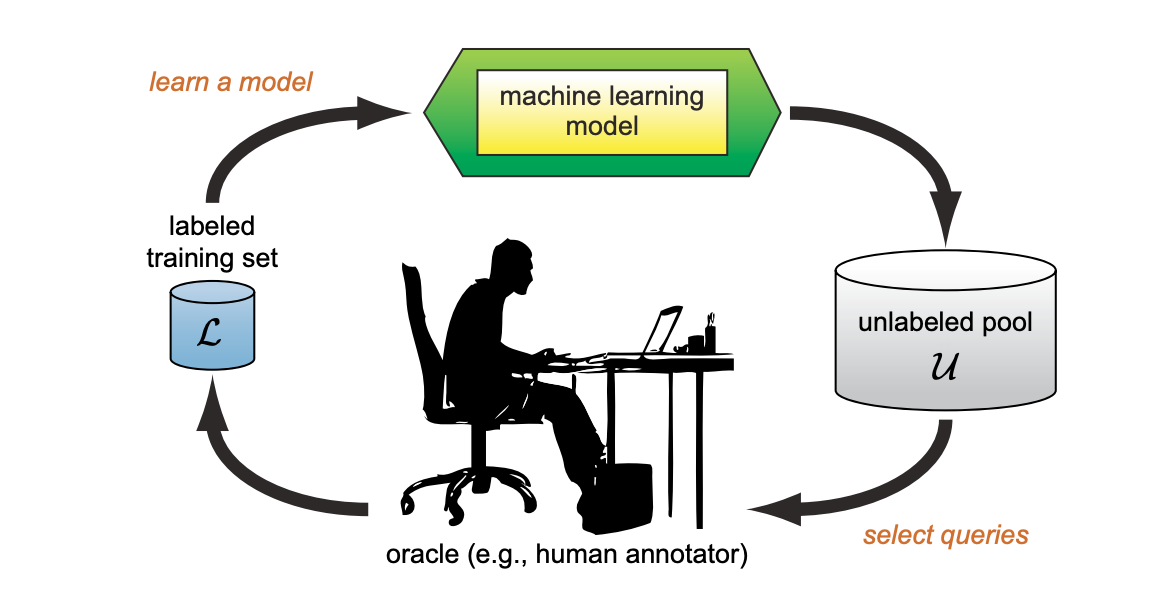